# Лабораторная работа 3

   по теме
                 
   **Регрессионная модель изменения цен на дома в Бостоне**

   Выполнил студент

   Группы БСТ1801

   Харатишвили Заза

In [3]:
## Импорт необходимых для работы библиотек
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import boston_housing
import matplotlib.pyplot as plt

In [4]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

## Вывод данных из библиотек
print(train_data.shape)
print(test_data.shape)
print(test_targets)

## Нормализация данных
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)

train_data /= std
test_data -= mean
test_data /= std

(404, 13)
(102, 13)
[ 7.2 18.8 19.  27.  22.2 24.5 31.2 22.9 20.5 23.2 18.6 14.5 17.8 50.
 20.8 24.3 24.2 19.8 19.1 22.7 12.  10.2 20.  18.5 20.9 23.  27.5 30.1
  9.5 22.  21.2 14.1 33.1 23.4 20.1  7.4 15.4 23.8 20.1 24.5 33.  28.4
 14.1 46.7 32.5 29.6 28.4 19.8 20.2 25.  35.4 20.3  9.7 14.5 34.9 26.6
  7.2 50.  32.4 21.6 29.8 13.1 27.5 21.2 23.1 21.9 13.  23.2  8.1  5.6
 21.7 29.6 19.6  7.  26.4 18.9 20.9 28.1 35.4 10.2 24.3 43.1 17.6 15.4
 16.2 27.1 21.4 21.5 22.4 25.  16.6 18.6 22.  42.8 35.1 21.5 36.  21.9
 24.1 50.  26.7 25. ]


In [5]:
## Определяем функцию построения модели скалярной регрессии

def build_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

#Метрика потерь: 
#Среднеквадратичная ошибка (Mean Squared Error) – 
#Среднее арифметическое (Mean) квадратов разностей 
#между предсказанными и реальными значениями

#Дополнительная метрика:
#средняя абсолютная ошибка (Mean Absolute Error) -
#рассчитывается как среднее значение ошибок прогноза

In [7]:
## Создание массивов для вывода метрик
all_scores = []
all_mae_histories = []
all_mse_histories = []

## Указываем количество блоков перекрестной проверки
k = 4

## Указываем данные обучения модели
num_val_samples = len(train_data) // k
num_epochs = 100

## Вызываем модели в цикле
for i in range(k):
    print('Номер прогона:  #%d' % i)
    # Подготовим тестовый прогон
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # Подготовим тренировочный прогон
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    #Строим модель
    model = build_model()
    
    #Обучаем модель
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    
    #Оценим модель на основе данных проверки
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    
    #Заполняем массивы данными метрик
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    
    mse_history = history.history['val_loss']
    all_mse_histories.append(mse_history)
    
print('Ошибки по четырем прогонам: ', all_scores)

print('Среднеквадратическая ошибка: ', np.mean(val_mse))
print('Средняя абсолютная ошибка: ', np.mean(val_mae))

print('Средняя ошибка: ', np.mean(all_scores))

Номер прогона:  #0
Номер прогона:  #1
Номер прогона:  #2
Номер прогона:  #3
Ошибки по четырем прогонам:  [2.1825356483459473, 2.698805332183838, 2.849130392074585, 2.362278938293457]
Среднеквадратическая ошибка:  10.752663612365723
Средняя абсолютная ошибка:  2.362278938293457
Средняя ошибка:  2.523187577724457


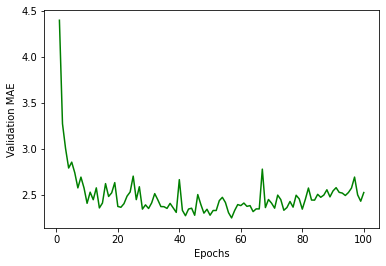

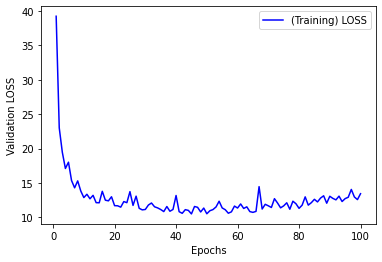

In [9]:
## Построим графики loss и mae

#Усредняем результаты метрик
average_mae_history_first =[
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]
average_mse_history_first =[
    np.mean([x[i] for x in all_mse_histories]) for i in range(num_epochs)
]

#Строим графики
plt.plot(range(1, len(average_mae_history_first) + 1), average_mae_history_first, 'g', label='(Training) MAE')
plt.ylabel('Validation MAE')
plt.xlabel('Epochs')
plt.figure()
plt.plot(range(1, len(average_mse_history_first) + 1), average_mse_history_first, 'b', label='(Training) LOSS')
plt.xlabel('Epochs')
plt.ylabel('Validation LOSS')
plt.legend()
plt.show()

Теперь увеличим количество эпох обучения и проанализируем полученные результаты

In [11]:
## Создание массивов для вывода метрик
all_scores = []
all_mae_histories = []
all_mse_histories = []

## Указываем количество блоков перекрестной проверки
k = 4

## Указываем данные обучения модели
num_val_samples = len(train_data) // k
num_epochs = 200

## Вызываем модели в цикле
for i in range(k):
    print('Номер прогона:  #%d' % i)
    # Подготовим тестовый прогон
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # Подготовим тренировочный прогон
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    #Строим модель
    model = build_model()
    
    #Обучаем модель
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    
    #Оценим модель на основе данных проверки
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    
    #Заполняем массивы данными метрик
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    
    mse_history = history.history['val_loss']
    all_mse_histories.append(mse_history)
    
print('Ошибки по четырем прогонам: ', all_scores)

print('Среднеквадратическая ошибка: ', np.mean(val_mse))
print('Средняя абсолютная ошибка: ', np.mean(val_mae))

print('Средняя ошибка: ', np.mean(all_scores))

Номер прогона:  #0
Номер прогона:  #1
Номер прогона:  #2
Номер прогона:  #3
Ошибки по четырем прогонам:  [2.4565675258636475, 3.141625165939331, 2.8508262634277344, 2.5186245441436768]
Среднеквадратическая ошибка:  12.095186233520508
Средняя абсолютная ошибка:  2.5186245441436768
Средняя ошибка:  2.7419108748435974


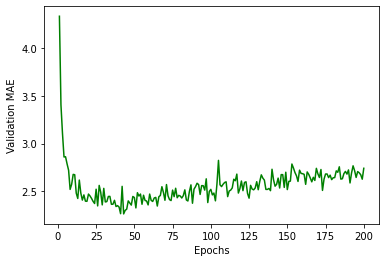

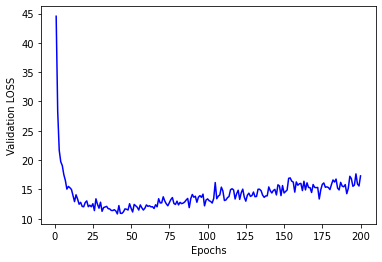

In [12]:
## Построим графики loss и mae

#Усредняем результаты метрик
average_mae_history_sec =[
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]
average_mse_history_sec =[
    np.mean([x[i] for x in all_mse_histories]) for i in range(num_epochs)
]

#Строим графики
plt.plot(range(1, len(average_mae_history_sec) + 1), average_mae_history_sec, 'g', label='(Training) MAE')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.figure()
plt.plot(range(1, len(average_mse_history_sec) + 1), average_mse_history_sec, 'b', label='(Training) LOSS')
plt.xlabel('Epochs')
plt.ylabel('Validation LOSS')
plt.show()

Теперь уменьшим количество эпох обучения и проанализируем полученные результаты

In [13]:
## Создание массивов для вывода метрик
all_scores = []
all_mae_histories = []
all_mse_histories = []

## Указываем количество блоков перекрестной проверки
k = 4

## Указываем данные обучения модели
num_val_samples = len(train_data) // k
num_epochs = 80

## Вызываем модели в цикле
for i in range(k):
    print('Номер прогона:  #%d' % i)
    # Подготовим тестовый прогон
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # Подготовим тренировочный прогон
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    #Строим модель
    model = build_model()
    
    #Обучаем модель
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    
    #Оценим модель на основе данных проверки
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    
    #Заполняем массивы данными метрик
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    
    mse_history = history.history['val_loss']
    all_mse_histories.append(mse_history)
    
print('Ошибки по четырем прогонам: ', all_scores)

print('Среднеквадратическая ошибка: ', np.mean(val_mse))
print('Средняя абсолютная ошибка: ', np.mean(val_mae))

print('Средняя ошибка: ', np.mean(all_scores))

Номер прогона:  #0
Номер прогона:  #1
Номер прогона:  #2
Номер прогона:  #3
Ошибки по четырем прогонам:  [1.8579325675964355, 2.5002284049987793, 2.523068428039551, 2.4434680938720703]
Среднеквадратическая ошибка:  12.143590927124023
Средняя абсолютная ошибка:  2.4434680938720703
Средняя ошибка:  2.331174373626709


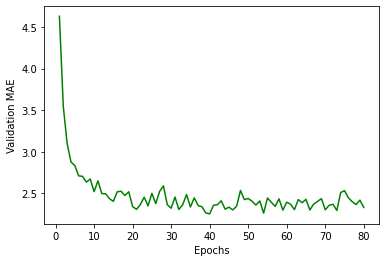

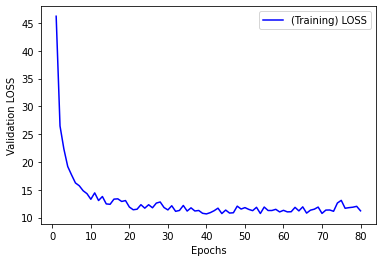

In [16]:
## Построим графики loss и mae

#Усредняем результаты метрик
average_mae_history_third =[
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]
average_mse_history_third =[
    np.mean([x[i] for x in all_mse_histories]) for i in range(num_epochs)
]

#Строим графики
plt.plot(range(1, len(average_mae_history_third) + 1), average_mae_history_third, 'g', label='(Training) MAE')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.figure()
plt.plot(range(1, len(average_mse_history_third) + 1), average_mse_history_third, 'b', label='(Training) LOSS')
plt.xlabel('Epochs')
plt.ylabel('Validation LOSS')
plt.legend()
plt.show()

Сравним результаты трех моделей на графиках:

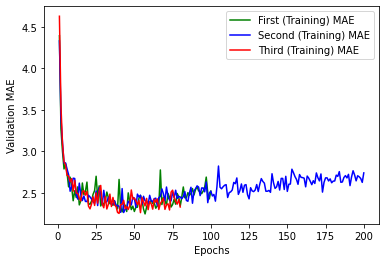

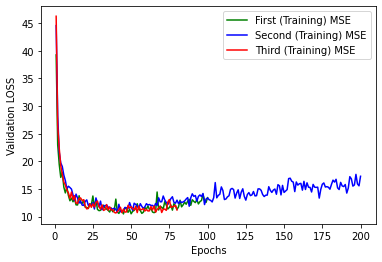

In [17]:
plt.plot(range(1, len(average_mae_history_first) + 1), average_mae_history_first, 'g', label='First (Training) MAE')
plt.plot(range(1, len(average_mae_history_sec) + 1), average_mae_history_sec, 'b', label='Second (Training) MAE')
plt.plot(range(1, len(average_mae_history_third) + 1), average_mae_history_third, 'r', label='Third (Training) MAE')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend()
plt.figure()

plt.plot(range(1, len(average_mse_history_first) + 1), average_mse_history_first, 'g', label='First (Training) MSE')
plt.plot(range(1, len(average_mse_history_sec) + 1), average_mse_history_sec, 'b', label='Second (Training) MSE')
plt.plot(range(1, len(average_mse_history_third) + 1), average_mse_history_third, 'r', label='Third (Training) MSE')
plt.xlabel('Epochs')
plt.ylabel('Validation LOSS')
plt.legend()

plt.show()

В результате анализа моделей можно увидеть, что сеть начинает переобучаться примерно после 80 эпох.

Теперь уменьшим количество блоков перекрестной проверки в два раза и сравним с предыдущей моделью

In [18]:
## Создание массивов для вывода метрик
all_scores = []
all_mae_histories = []
all_mse_histories = []

## Указываем количество блоков перекрестной проверки
k = 2

## Указываем данные обучения модели
num_val_samples = len(train_data) // k
num_epochs = 80

## Вызываем модели в цикле
for i in range(k):
    print('Номер прогона:  #%d' % i)
    # Подготовим тестовый прогон
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # Подготовим тренировочный прогон
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    #Строим модель
    model = build_model()
    
    #Обучаем модель
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    
    #Оценим модель на основе данных проверки
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    
    #Заполняем массивы данными метрик
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    
    mse_history = history.history['val_loss']
    all_mse_histories.append(mse_history)
    
print('Ошибки по четырем прогонам: ', all_scores)

print('Среднеквадратическая ошибка: ', np.mean(val_mse))
print('Средняя абсолютная ошибка: ', np.mean(val_mae))

print('Средняя ошибка: ', np.mean(all_scores))

Номер прогона:  #0
Номер прогона:  #1
Ошибки по четырем прогонам:  [2.592233896255493, 2.59359073638916]
Среднеквадратическая ошибка:  15.183548927307129
Средняя абсолютная ошибка:  2.59359073638916
Средняя ошибка:  2.5929123163223267


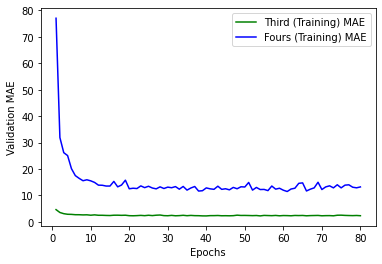

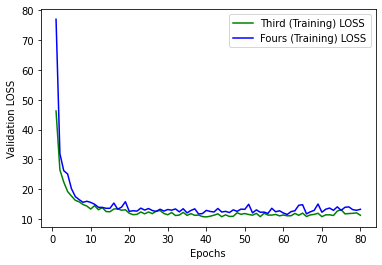

In [19]:
## Построим графики loss и mae

#Усредняем результаты метрик
average_mae_history_fours =[
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]
average_mse_history_fours =[
    np.mean([x[i] for x in all_mse_histories]) for i in range(num_epochs)
]

#Строим графики
plt.plot(range(1, len(average_mae_history_third) + 1), average_mae_history_third, 'g', label='Third (Training) MAE')
plt.plot(range(1, len(average_mse_history_fours) + 1), average_mse_history_fours, 'b', label='Fours (Training) MAE')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend()
plt.figure()

plt.plot(range(1, len(average_mse_history_third) + 1), average_mse_history_third, 'g', label='Third (Training) LOSS')
plt.plot(range(1, len(average_mse_history_fours) + 1), average_mse_history_fours, 'b', label='Fours (Training) LOSS')
plt.xlabel('Epochs')
plt.ylabel('Validation LOSS')
plt.legend()
plt.show()

Теперь увеличим количество блоков перекрестной проверки и сравним с предыдущими модельями

In [20]:
## Создание массивов для вывода метрик
all_scores = []
all_mae_histories = []
all_mse_histories = []

## Указываем количество блоков перекрестной проверки
k = 6

## Указываем данные обучения модели
num_val_samples = len(train_data) // k
num_epochs = 80

## Вызываем модели в цикле
for i in range(k):
    print('Номер прогона:  #%d' % i)
    # Подготовим тестовый прогон
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # Подготовим тренировочный прогон
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    #Строим модель
    model = build_model()
    
    #Обучаем модель
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    
    #Оценим модель на основе данных проверки
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    
    #Заполняем массивы данными метрик
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    
    mse_history = history.history['val_loss']
    all_mse_histories.append(mse_history)
    
print('Ошибки по четырем прогонам: ', all_scores)

print('Среднеквадратическая ошибка: ', np.mean(val_mse))
print('Средняя абсолютная ошибка: ', np.mean(val_mae))

print('Средняя ошибка: ', np.mean(all_scores))

Номер прогона:  #0
Номер прогона:  #1
Номер прогона:  #2
Номер прогона:  #3
Номер прогона:  #4
Номер прогона:  #5
Ошибки по четырем прогонам:  [2.059297561645508, 2.5246126651763916, 2.05000376701355, 2.451815128326416, 2.853792428970337, 2.044351577758789]
Среднеквадратическая ошибка:  6.6248779296875
Средняя абсолютная ошибка:  2.044351577758789
Средняя ошибка:  2.330645521481832


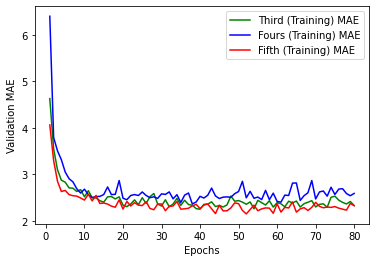

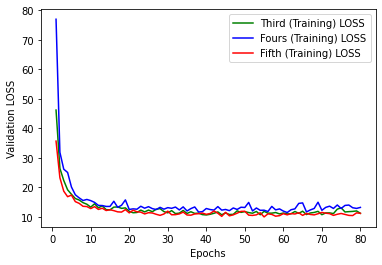

In [21]:
## Построим графики loss и mae

#Усредняем результаты метрик
average_mae_history_fifth =[
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]
average_mse_history_fifth =[
    np.mean([x[i] for x in all_mse_histories]) for i in range(num_epochs)
]

#Строим графики
plt.plot(range(1, len(average_mae_history_third) + 1), average_mae_history_third, 'g', label='Third (Training) MAE')
plt.plot(range(1, len(average_mae_history_fours) + 1), average_mae_history_fours, 'b', label='Fours (Training) MAE')
plt.plot(range(1, len(average_mae_history_fifth) + 1), average_mae_history_fifth, 'r', label='Fifth (Training) MAE')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend()
plt.figure()

plt.plot(range(1, len(average_mse_history_third) + 1), average_mse_history_third, 'g', label='Third (Training) LOSS')
plt.plot(range(1, len(average_mse_history_fours) + 1), average_mse_history_fours, 'b', label='Fours (Training) LOSS')
plt.plot(range(1, len(average_mse_history_fifth) + 1), average_mse_history_fifth, 'r', label='Fifth (Training) LOSS')
plt.xlabel('Epochs')
plt.ylabel('Validation LOSS')
plt.legend()
plt.show()

## Вывод

В результате сравнения моделей